# Foundations of Machine Learning

In this notebook, we will learn about the basics of machine learning. 

At the start, we will implement various **loss and risk** estimation functions.

Subsequently, we will implement a **binary logistic regression** (BLR) model according to the [scikit-learn guidelines](https://scikit-learn.org/stable/developers/develop.html).

Further, we will introduce **nonlinear basis functions** as a prerequisite for nonlinear decision boundaries when using BLR models.

Finally, we apply BLR models to an artificial data set to investigate the **under- and overfitting** issue.

### **Table of Contents**
1. [Loss Functions and Notions of Risk](#loss-functions-and-notions-of-risk)
2. [Binary Logistic Regression](#binary-logistic-regression)
3. [Nonlinear Basis Functions](#basis-functions)
4. [Under- and Overfitting](#under-overfitting)

In [1]:
import sklearn.model_selection
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np

from math import isclose
from ipywidgets import interactive, IntSlider, FloatSlider

### **1. Loss Functions and Notions of Risk** <a class="anchor" id="loss-functions-and-notions-of-risk"></a>

The most popular loss function in classification is the zero-one loss function $L_{0/1}$, which is given by

$L_{0/1} (y, y') =  \delta (y \neq y') = \left\{
\begin{array}{ll}
1 & y \neq y' \\
0 & y = y' \\
\end{array}
\right. $

#### **Question:**
1. (a) What are the reasons that the zero-one loss function $L_{0/1}$ is typically used for assessing a classifier but not for training?

   counts number of errors
   $L_{0/1}$ is non-convex, non-smooth, non-differential and non-continuous -> possibly almost impossible to find global minimum -> better loss functions which support gradient descent etc.
   
Alternative loss functions have been proposed that are suitable for optimizing a classifier during training. One of such functions is the *binary cross entropy* (BCE) loss function $L_\mathrm{BCE}$, which is given by:

   $L_\mathrm{BCE}(p, p') = -p*ln(p') - (1-p)*ln(1 - p')$,
   $p \in [0,1]$ = true label/probability
   $p' \in [0,1]$ = estimated label/probability

#### **Question:**
1. (b) Is the BCE loss function convex with respect to the estimated probability? Prove your answer.

   *Remark: A function $f$ is convex in an interval $\mathcal{I}$, if $\forall x \in \mathcal{I}: f^{\prime\prime}(x) \geq 0$.*
   convex <-> There is no intersection with function, if we put a line between two points in the graph

   Yes:
   $f^{\prime}(p') = \frac{1-p}{1-p'}-\frac{p}{p'} = - \frac{p'-p}{(p'-1)p}$
   $f^{\prime \prime}(p') = \frac{1-p}{(1-p')^2}+\frac{p}{p'^2}$

    Since $p \in [0,1], f^{\prime \prime}(p') \geq 0$.
    Since $p \in (0,1)$, the denominator can not be 0.

    -> $\forall x \in \mathcal{I}: f^{\prime\prime}(x) \geq 0$
   
For a given loss function $L$ and a dataset $\mathcal{D}$, the empirical risk $R_{\mathcal{D}}(h)$ of a classifier $h$ is given by:

$R_{\mathcal{D}}(h) = \frac{1}{|D|}*\sum{(x,y)\in D}{}L(y,h(x))$

The expected risk is not on the dataset D, but on the real distribution (usually not known).
The empirical risk is on the dataset D.

With this knowledge, we implement the empirical risk for the zero-one loss function $L_{0/1}$ and the BCE loss function $L_{\mathrm{BCE}}$ in the Python file [`e2ml.evaluation._loss_functions`](../e2ml/evaluation/_loss_functions.py). Afterwards, we check our code by executing the following cell.

In [2]:
from e2ml.evaluation import zero_one_loss, binary_cross_entropy_loss

y_true = [0, 1, 0, 1, 0]
y_pred = [0, 0, 0, 1, 0]
check = zero_one_loss(y_true, y_pred) == 0.2
assert check, 'The empirical risk must be 0.2 for this data set.' 

y_true = [0, 1, 0, 1, 0]
y_pred = [0, 0.9, 0.1, 0.5, 0.5]    # normally 0 or 1 is not allowed
check = isclose(binary_cross_entropy_loss(y_true, y_pred), 0.319, abs_tol=0.001)
assert check, 'The empirical risk must be around 0.319 for this data set.' 

y_true_list = [[2], [-1], [0.5], [0.5]]
y_pred_list = [[0.5], [0.5], [2], [-1]]
for y_true, y_pred in zip(y_true_list, y_pred_list):
    check = False
    try:
        binary_cross_entropy_loss(y_true, y_pred)
    except ValueError:
        check = True
    assert check, 'There must be a ValueError because of invalid values.' 

### **2. Binary Logistic Regression** <a class="anchor" id="binary-logistic-regression"></a>

*Binary logistic regression* (BLR) is a space of classifiers optimizing the BCE loss function. Instead of a class label, a BLR model with weights $\mathbf{w} \in \mathbb{R}^M$ and $\boldsymbol{\phi}: \mathbb{R}^D \rightarrow \mathbb{R}^M$ as a vector of $M$ basis functions estimates the conditional probability according to:


$h_w(\phi(x))= p(y=1|\phi(x);w)=\sigma(\phi(x)^Tw) = \frac{1}{1+exp(-\phi(x)^Tw)}$

For a *regularized risk minimization* (RRM) algorithm, we train a BLR model by optimizing

Folie 33:
$R_D(h_w) + J(h_w))$

For optimization, we could use a gradient descent approach:

$$\mathbf{w}_{t+1} = \mathbf{w}_t - \eta \cdot \nabla\left(R_\mathcal{D}(\mathbf{w}_t) + J(h_\mathbf{w})\right),$$

where $\nabla$ denotes the gradient, $t$ the current optimization step, and $\eta \in \mathbb{R}_{>0}$ the learning rate defining the step size in each optimization step. The initial weights $\mathbf{w}_0$ can be chosen randomly and the subsequent optimization steps can be repeated until a stopping criterion is reached, e.g., maximum number of steps. The gradient $\nabla\left(R_\mathcal{D}(\mathbf{w}_t) + J(h_\mathbf{w})\right)$ with respect to the weights $\mathbf{w}$ is then given by:

what is the gradient?
(c.f. stackoverflow of forum)
$R_D(h_w) = \frac{1}{|D|}*\sum{(x,y)\in D} L_{BCE} (y, h_w(\phi(x)))$
$J(h_w) = \frac{\gamma}{2*|D|}w^Tw$

$L_\mathrm{BCE}(p, p') = -p*ln(p') - (1-p)*ln(1 - p')$
Gradient G $= - y * ln(h_w(\phi(x)) - (1 - y) * ln(h_w(1 - \phi(x))$
$h = h_w(\phi(x)), z = \phi(x)$
$\frac{\sigma G}{\sigma w} = \frac{\sigma G}{\sigma h} \frac{\sigma h}{\sigma z}$ chain rule: $\frac{\sigma G}{\sigma h} = \frac{1-y}{h} -\frac{y}{h}$
$(1 + e^z)^{-1\prime} = \frac{-(1 + e^{-z})^{-1\prime}}{(1+ e^{-z})^2} = \frac{(e^{-z})}{(1+ e^{-z})^2} = \frac{1}{(1+ e^{-z})}* \frac{(e^{-z})}{(1+ e^{-z})} = \frac{1}{(1+ e^{-z})}* (\frac{(1 + e^{-z})}{(1+ e^{-z})} - \frac{1}{(1+ e^{-z})}) = h * (\frac{1 + e^{-z}}{1+ e^{-z}} - h) = h (1-h)$


$\frac{\sigma}{\sigma w} = -\phi(x)^Tw\frac{\sigma}{\sigma w} = - \phi(x)^T$

result:
$\frac{\sigma}{\sigma w}R_D(h_w) = \frac{1}{|D|}  \sum{(x,y)\in D}((h_w(\phi(x)-y)*\phi(x))$

Derive $J(h_w) = \frac{\gamma}{2*|D|}w^Tw$
$J(h_w)\prime = \frac{1}{|D|}w$

-> sum up both derivations for complete solution


With this knowledge, we implement the class [`BinaryLogisticRegression`](../e2ml/models/_binary_logistic_regression.py) in the [`e2ml.models`](../e2ml/models) subpackage. However, there we use [L-BFGS-B](https://en.wikipedia.org/wiki/Limited-memory_BFGS) as a so-called quasi-Netwon algorithm, which is an advancement of the standard gradient descent algorithm. Once, the implementation has been completed, we check its validity on a simple two-dimensional artificial dataset. 

In [3]:
from sklearn.datasets import make_blobs

from e2ml.models import BinaryLogisticRegression

# Create linearly separable dataset.
X, y = make_blobs(n_samples=100, centers=[[-1, -1], [1, 1]], cluster_std=0.1, random_state=0)

# Fit `BinaryLogisticRegression` with `maxiter=1` and `lmbda=0` on the artificial data set.
BLR = BinaryLogisticRegression(maxiter=1, lmbda=0)
BLR.fit(X=X, y=y)

# Make predictions using the fitted `BinaryLogisticRegression` model on the training set `X`.
y_pred = BLR.predict(X)

# Compute empirical risk as `risk` with the zero-one loss function on the training set `X`.
risk = zero_one_loss(y_true=y, y_pred=y_pred)

assert risk == 0, 'The classifier must reach an accuracy of 1.0 for this data set.'

### **3. Nonlinear Basis Functions** <a class="anchor" id="basis-functions"></a>

For certain learning tasks, it is useful to add complexity to a machine learning model by considering
nonlinear transformations of the samples. 

**Definition 3.12** <font color='red'>**Nonlinear Basis Functions**</font> 

Nonlinear basis functions $\boldsymbol{\phi}: \mathbb{R}^D \rightarrow \mathbb{R}^M$ nonlinearly transform a $D$-dimensional instance $\mathbf{x} \in \mathbb{R}^D$ to an $M$-dimensional features space $\mathbb{R}^M$ according to:

$$\boldsymbol{\phi}(\mathbf{x}) = \begin{bmatrix} \phi_1(\mathbf{x}) \\ \vdots \\ \phi_M(\mathbf{x}) \end{bmatrix}.$$

**Remark:** With nonlinear basis functions, a (generalized) linear machine learning model, e.g., BLR, can output nonlinear outputs, e.g., decision boundaries.

**Examples:** Two popular types of nonlinear basis functions are: 
- *multivariate polynomials* with a user-defined maximum degree, e.g., for a degree of two and a two-dimensional instance, we get

  $$\boldsymbol{\phi}(\mathbf{x}) = \boldsymbol{\phi}\left(\begin{bmatrix} x_1 \\ x_2 \end{bmatrix}\right) = \begin{bmatrix} 1 \\ x_1 \\ x_2 \\ x_1 \cdot x_2 \\ x_1^2 \\ x_2^2 \end{bmatrix},$$
  
- and *Gaussian basis functions* of the form

  $$\phi_j(\mathbf{x}) = \exp\left(\frac{-||\mathbf{x} - \boldsymbol{\mu}_j||_2^2}{2 \sigma_j^2}\right),$$

  where $\boldsymbol{\mu} \in \mathbb{R}^D$ controls the position of the $j$-th basis function and the parameter $\sigma_j \in \mathbb{R}_>0$ its spatial extension.
  
In the following, we exemplary illustrate the use of Gaussian basis functions. For this purpose, we want to define two basis functions such that the transformed instances define a linearly separable training set, i.e., it should be possible to draw a single straight line separating the blue from the red instances.

interactive(children=(FloatSlider(value=-7.5, description='mu_11', max=10.0, min=-10.0), FloatSlider(value=5.5…

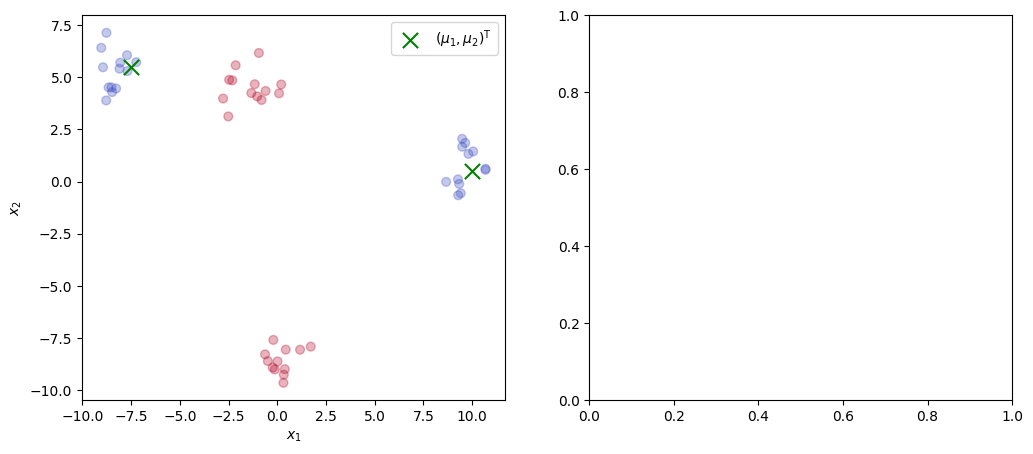

In [7]:
from sklearn.metrics.pairwise import euclidean_distances

def visualize_gaussian_basis_functions(mu_11, mu_12, mu_21, mu_22, sigma_1, sigma_2):
    """
    Visualizes the application of Gaussian basis functions.
    
    Parameters
    ----------
    mu_11 : float
        First value of mu_1 of the first basis function.
    mu_12 : float
        Second value of mu_1 of the first basis function.
    mu_21 : float
        First value of mu_2 of the second basis function.
    mu_22 : float
        Second value of mu_2 of the second basis function.
    sigma_1 : positive float
        Spatial extension of the first basis function.
    sigma_2 : positive float
        Spatial extension of the second basis function.
    """
    X, y = make_blobs(n_samples=50, centers=4, random_state=7, cluster_std=0.75)
    y %= 2
    
    # Define array of `mus`.
    mus = np.array([[mu_11, mu_12],[mu_21, mu_22]])
    
    # Define array of `sigmas`.
    sigmas = np.array([sigma_1, sigma_2])
    
    # Compute transformation via Gaussian basis functions.
    Phi =  np.exp(-1/(2*sigmas) * np.linalg.norm(list(map(lambda x: x - mus, X)))**2)
    
    # Plot results.
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', s=40, alpha=0.3)
    plt.scatter(mus[:, 0], mus[:, 1], c="green", s=120, marker="x", label="$(\mu_1, \mu_2)^\mathrm{T}$")
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.scatter(Phi[:, 0], Phi[:, 1], c=y, cmap='coolwarm', s=40, alpha=0.3)
    plt.xlabel("$\phi_1$")
    plt.ylabel("$\phi_2$")
    plt.show()


interactive(
    visualize_gaussian_basis_functions, 
    mu_11=FloatSlider(value=-7.5, min=-10, max=10),
    mu_12=FloatSlider(value=5.5, min=-10, max=10),
    mu_21=FloatSlider(value=10, min=-10, max=10),
    mu_22=FloatSlider(value=0.5, min=-10, max=10),
    sigma_1=FloatSlider(value=1, min=0.1, max=10),
    sigma_2=FloatSlider(value=1, min=0.1, max=10),
)

#### **Questions:**
3. (a) What is a suitable parametrization of the above basis functions for obtaining a linearly separable transformation?

    D.h. Parameter, sodass Strich beide Klassen teilt
   mu_11 x-achse
   mu_12, mu_22  y-achse -> Richtung rote Wolken -> Lineare Separierbarkeit
   Sigma_1: klein -> X-Achse Richtung 0, groß -> Daten aufblähen
   Sigma_2: klein -> Y-Achse Richtung 0, groß -> Daten aufblähen

    Sigmas groß machen -> weiter weg von null
    Basisfunktionen müssen alle auf eine Klasse ausgerichtet sein (Kreuz auf jeweils ein Zentrum der gleichen Farbe) -> Linear separierbar


### **4. Under- and Overfitting** <a class="anchor" id="under-overfitting"></a>

For our two-dimensional data set, we want to visualize the BLR models estimated decision boundaries including the estimated class-membership probabilities.
For this purpose, we implement the function [`plot_decision_boundary`](../e2ml/evaluation/_visualization.py) in the [`e2ml.evaluation`](../e2ml/evaluation) subpackage.

Given this function, we create an interactive visualization in the following.

interactive(children=(IntSlider(value=1000, description='maxiter', max=10000), FloatSlider(value=0.0, descript…

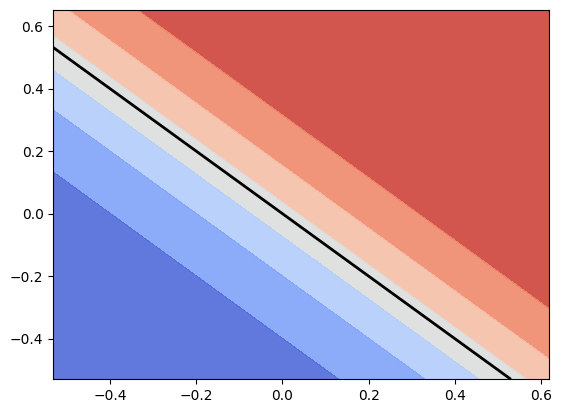

In [5]:
from e2ml.evaluation import plot_decision_boundary
from sklearn.pipeline import make_pipeline
from sklearn.datasets import make_classification
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split


def visualize_blr(maxiter, lmbda, degree, train_ratio, random_state):
    """
    Visualize decision boundary and estimated conditional class probabilities for a BLR model.
    
    Parameters
    ----------
    maxiter : positive int
        Number of maximum optimization iterations.
    lmbda : non-negative float
        Regularization rate used by the RRM algorithm.
    degree : non-negative int
        Maximum degree of the multivariate polynomial.
    train_ratio : float in (0, 1)
        Ratio of training samples.
    """
    # Generate dataset.
    X, y = make_classification(
        n_samples=100,
        n_features=2,
        n_redundant=0,
        flip_y=0.25,
        random_state=100,
        scale=0.1,
        class_sep=1.5,
    )
    
    # Get boundaries of the feature space.
    bound=[[X[:, 0].min()-0.2, X[:, 1].min()-0.2], [X[:, 0].max()+0.2, X[:, 1].max()+0.2]]
    
    # Randomly split train and test data by creating the index arrays `train_idx` and `test_idx`.
    train_idx, test_idx, y_train, y_test = train_test_split(X, y, train_size=train_ratio)
    
    # Create polynomial feature transformation `poly` with `degree`.
    poly = PolynomialFeatures(degree=degree)
    
    # Create `blr` model with `n_optimization_steps` and `lmbda`.
    n_optimization_steps = maxiter
    blr = BinaryLogisticRegression(maxiter=n_optimization_steps, lmbda=lmbda)
    
    # Create pipeline.
    clf = make_pipeline(poly, blr)
    
    # Fit `BinaryLogisticRegression` as `clf` on training data.
    clf = blr.fit(train_idx, y_train)
    
    # Compute zero-one loss on train and test data, i.e., `train_error` and `test_error`.
    train_error = zero_one_loss(y_true=y_train, y_pred=clf.predict(X=train_idx))
    test_error = zero_one_loss(y_true=y_test, y_pred=clf.predict(X=test_idx))
    
    # Plot results.
    plot_decision_boundary(clf=clf, bound=bound)
    plt.scatter(
        X[train_idx, 0],
        X[train_idx, 1],
        marker='o',
        label='Training Samples',
        facecolors='none',
        edgecolors='k',
        linewidth=4, 
        s=60
    )
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', s=40)
    plt.title(f'Train Error: {round(train_error, 3)}, Test Error: {round(test_error, 3)}')
    plt.legend()
    plt.show()
    
interactive(
    visualize_blr, 
    maxiter=IntSlider(value=1000, min=0, max=10000), 
    eta=FloatSlider(value=1, min=0, max=10), 
    lmbda=FloatSlider(value=0.0, min=0.0, max=10, step=0.001),
    degree=IntSlider(value=1, min=1, max=10), 
    train_ratio=FloatSlider(value=0.5, min=0.02, max=0.98, step=0.01),
    random_state=IntSlider(value=0, min=0, max=10),
)

The interactive visualization allows us to study the effect of the two parameters `lmbda` and `degree`. In particular, we can study the phonemes of under- and overfitting to answer the following questions:

#### Questions:
4. (a) How does the regularization rate `lmbda` affect the BLR model's decision boundary and its estimated class-membership probabilities? How is it related to over- and underfitting?

   regularization rate = increase - > colors shift back and forth and size changes
   
  (b) How does the `degree` of the polynomial affect the BLR model's decision boundary and its estimated class-membership probabilities? How is it related to over- and underfitting?

   degree = increase -> allowing functions of higher degree, more curves


train_ratio = increase of amount of data to train
